In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../'))

import numpy as np
from matplotlib import pyplot as plt
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import lagrange
from dg_maxwell import wave_equation as w1d

af.set_backend('opencl')
af.set_device(1)
af.info()

plt.rcParams['figure.figsize']     = 12, 7.5
plt.rcParams['lines.linewidth']    = 1.5
plt.rcParams['font.family']        = 'serif'
plt.rcParams['font.weight']        = 'bold'
plt.rcParams['font.size']          = 20  
plt.rcParams['font.sans-serif']    = 'serif'
plt.rcParams['text.usetex']        = True
plt.rcParams['axes.linewidth']     = 1.5
plt.rcParams['axes.titlesize']     = 'medium'
plt.rcParams['axes.labelsize']     = 'medium'

plt.rcParams['xtick.major.size']   = 8
plt.rcParams['xtick.minor.size']   = 4
plt.rcParams['xtick.major.pad']    = 8
plt.rcParams['xtick.minor.pad']    = 8
plt.rcParams['xtick.color']        = 'k'
plt.rcParams['xtick.labelsize']    = 'medium'
plt.rcParams['xtick.direction']    = 'in'    

plt.rcParams['ytick.major.size']   = 8
plt.rcParams['ytick.minor.size']   = 4
plt.rcParams['ytick.major.pad']    = 8
plt.rcParams['ytick.minor.pad']    = 8
plt.rcParams['ytick.color']        = 'k'
plt.rcParams['ytick.labelsize']    = 'medium'
plt.rcParams['ytick.direction']    = 'in'
plt.rcParams['text.usetex']        = True
plt.rcParams['text.latex.unicode'] = True

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [2]:
# 1. Set the initial conditions

E_00 = 1.
E_01 = 1.

B_00 = 0.2
B_01 = 0.5

E_z_init = E_00 * af.sin(2 * np.pi * params.element_LGL) \
         + E_01 * af.cos(2 * np.pi * params.element_LGL)

B_y_init = B_00 * af.sin(2 * np.pi * params.element_LGL) \
         + B_01 * af.cos(2 * np.pi * params.element_LGL)

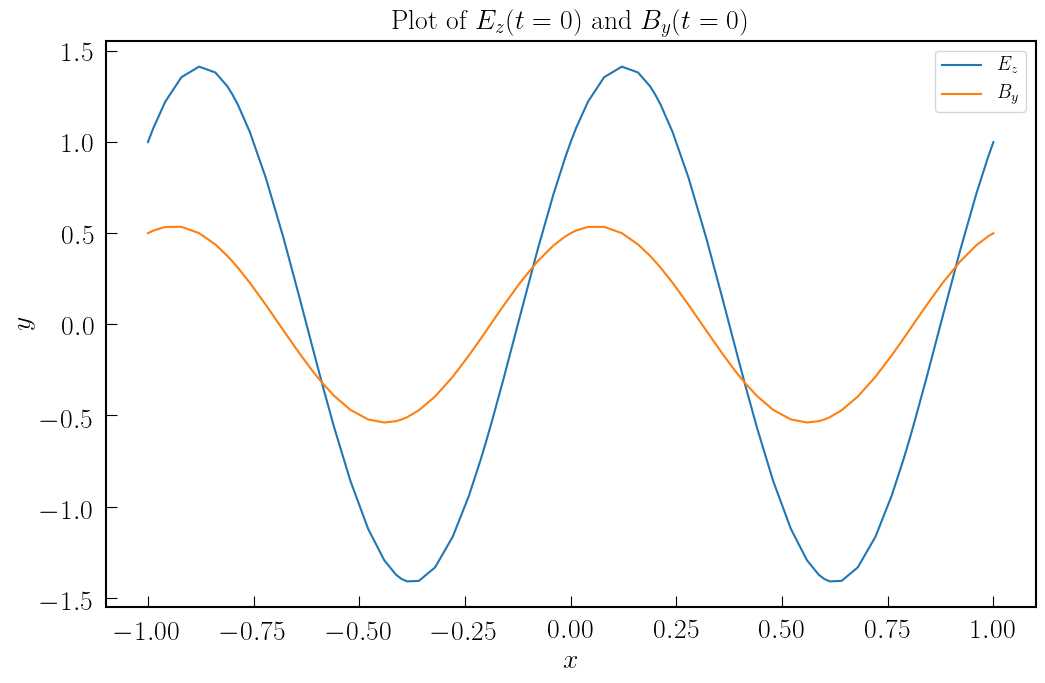

In [3]:
element_LGL_flat = af.flat(params.element_LGL)
E_z_init_flat    = af.flat(E_z_init)
B_y_init_flat    = af.flat(B_y_init)

plt.plot(element_LGL_flat, E_z_init_flat, label = r'$E_z$')
plt.plot(element_LGL_flat, B_y_init_flat, label = r'$B_y$')

plt.title(r'Plot of $E_z(t = 0)$ and $B_y(t = 0)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.legend(prop={'size': 14})

plt.show()

In [4]:
# 2. Modify the volume term to take flux as an argument.

def volume_integral_flux(u_n, flux_n):
    '''

    Calculates the volume integral of flux in the wave equation.

    :math:`\\int_{-1}^1 f(u) \\frac{d L_p}{d\\xi} d\\xi`

    This will give N values of flux integral as p varies from 0 to N - 1.
    
    This integral is carried out using the analytical form of the integrand
    obtained as a linear combination of Lagrange basis polynomials.

    This integrand is the used in the integrate() function.

    Calculation of volume integral flux using N_LGL Lobatto quadrature points
    can be vectorized and is much faster.
    
    Parameters
    ----------

    u : arrayfire.Array [N_LGL N_Elements 1 1]
        Amplitude of the wave at the mapped LGL nodes of each element.

    flux_n : arrayfire:Array [N_LGL N_Elements 1 1]
             Flux of the wave at the mapped LGL nodes of each element.

    Returns
    -------

    flux_integral : arrayfire.Array [N_LGL N_Elements 1 1]
                    Value of the volume integral flux. It contains the integral
                    of all N_LGL * N_Element integrands.

    '''
    # The coefficients of dLp / d\xi
    diff_lag_coeff  = params.dl_dxi_coeffs

    lobatto_nodes   = params.lobatto_quadrature_nodes
    Lobatto_weights = params.lobatto_weights_quadrature

    nodes_tile   = af.transpose(af.tile(lobatto_nodes, 1, diff_lag_coeff.shape[1]))
    power        = af.flip(af.range(diff_lag_coeff.shape[1]))
    power_tile   = af.tile(power, 1, params.N_quad)
    nodes_power  = nodes_tile ** power_tile
    weights_tile = af.transpose(af.tile(Lobatto_weights, 1, diff_lag_coeff.shape[1]))
    nodes_weight = nodes_power * weights_tile

    dLp_dxi      = af.matmul(diff_lag_coeff, nodes_weight)


    # The first option to calculate the volume integral term, directly uses
    # the Lobatto quadrature instead of using the integrate() function by
    # passing the coefficients of the Lagrange interpolated polynomial.
    if(params.volume_integral_scheme == 'lobatto_quadrature' \
        and params.N_quad == params.N_LGL):

        # Flux using u_n, reordered to 1 X N_LGL X N_Elements array.
        F_u_n                  = af.reorder(flux_n, 2, 0, 1)

        # Multiplying with dLp / d\xi
        integral_expansion     = af.broadcast(utils.multiply,
                                              dLp_dxi, F_u_n)

        # Using the quadrature rule.
        flux_integral = af.sum(integral_expansion, 1)
        flux_integral = af.reorder(flux_integral, 0, 2, 1)

    # Using the integrate() function to calculate the volume integral term
    # by passing the Lagrange interpolated polynomial.
    else:
        #print('option3')
        analytical_flux_coeffs = lagrange.lagrange_interpolation_u(flux_n)

        analytical_flux_coeffs = af.reorder(analytical_flux_coeffs, 1, 0, 2)

        dl_dxi_coefficients    = af.reorder(params.dl_dxi_coeffs, 1, 0)

        # The product of polynomials is calculated using af.convolve1
        volume_int_coeffs = af.convolve1(dl_dxi_coefficients,
                                         analytical_flux_coeffs,
                                         conv_mode=af.CONV_MODE.EXPAND)
        volume_int_coeffs = af.reorder(volume_int_coeffs, 1, 2, 0)
        volume_int_coeffs = af.moddims(volume_int_coeffs,
                                       params.N_LGL * params.N_Elements,
                                       2 * params.N_LGL - 2)

        flux_integral = lagrange.integrate(volume_int_coeffs)
        flux_integral = af.moddims(flux_integral, params.N_LGL, params.N_Elements)


    return flux_integral


In [11]:
# 3. Modify the Lax Friedrichs flux to accept the f_n and f_n+1 as argument

def lax_friedrichs_flux_u_n_flux_n(u_n, flux_n):
    '''

    Calculates the lax-friedrichs_flux :math:`f_i` using.

    :math:`f_i = \\frac{F(u^{i + 1}_0) + F(u^i_{N_{LGL} - 1})}{2} - \\frac
                {\Delta x}{2\Delta t} (u^{i + 1}_0 - u^i_{N_{LGL} - 1})`

    The algorithm used is explained in this `document`_

    .. _document: `https://goo.gl/sNsXXK`


    Parameters
    ----------

    u_n : arrayfire.Array [N_LGL N_Elements 1 1]
          Amplitude of the wave at the mapped LGL nodes of each element.

    flux_n : arrayfire:Array [N_LGL N_Elements 1 1]
             Flux of the wave at the mapped LGL nodes of each element.

    Returns
    -------

    boundary_flux : arrayfire.Array [1 N_Elements 1 1]
                    Contains the value of the flux at the boundary elements.
                    Periodic boundary conditions are used.

    '''
    
    u_iplus1_0    = af.shift(u_n[0, :], 0, -1)
    flux_iplus1_0 = af.shift(u_n[0, :], 0, -1)

    u_i_N_LGL    = u_n[-1, :]
    flux_i_N_LGL = flux_n[-1, :]

    flux_iplus1_0 = flux_x(u_iplus1_0)
    flux_i_N_LGL  = flux_x(u_i_N_LGL)
    
    boundary_flux = (flux_iplus1_0 + flux_i_N_LGL) / 2 \
                        - params.c_lax * (u_iplus1_0 - u_i_N_LGL) / 2
    
    
    return boundary_flux 


In [ ]:
# 4. Modufy the surface term to work for flux as an argument.

def surface_term_u_n_flux_n(u_n, flux_i):
    '''

    Calculates the surface term,
    :math:`L_p(1) f_i - L_p(-1) f_{i - 1}`
    using the lax_friedrichs_flux function and lagrange_basis_value
    from params module.
    
    Parameters
    ----------
    u_n : arrayfire.Array [N_LGL N_Elements 1 1]
          Amplitude of the wave at the mapped LGL nodes of each element.

    flux_n : af.Array [N_LGL N_Elements 1 1]
             Flux of the wave at the mapped LGL nodes of each element.

    Returns
    -------
    surface_term : arrayfire.Array [N_LGL N_Elements 1 1]
                   The surface term represented in the form of an array,
                   :math:`L_p (1) f_i - L_p (-1) f_{i - 1}`, where p varies
                   from zero to :math:`N_{LGL}` and i from zero to
                   :math:`N_{Elements}`. p varies along the rows and i along
                   columns.
    
    **See:** `PDF`_ describing the algorithm to obtain the surface term.
    
    .. _PDF: https://goo.gl/Nhhgzx

    '''

    L_p_minus1   = params.lagrange_basis_value[:,  0]
    L_p_1        = params.lagrange_basis_value[:, -1]
#     f_i          = lax_friedrichs_flux(u_n)
    f_iminus1    = af.shift(flux_i, 0, 1)
    surface_term = af.blas.matmul(L_p_1, flux_i) \
                 - af.blas.matmul(L_p_minus1, f_iminus1)
    
    return surface_term


In [ ]:
# 5. Modify the b vector to accept the flux as an argument

def b_vector_u_n_flux_n(u_n, flux_n):
    '''

    Calculates the b vector for N_Elements number of elements.
    
    Parameters
    ----------

    u_n : arrayfire.Array [N_LGL N_Elements 1 1]
          Amplitude of the wave at the mapped LGL nodes of each element.

    flux_n : af.Array [N_LGL N_Elements 1 1]
             Flux of the wave at the mapped LGL nodes of each element.

    Returns
    -------

    b_vector_array : arrayfire.Array [N_LGL N_Elements 1 1]
                     Contains the b vector(of shape [N_LGL 1 1 1])
                     for each element.

    **See:** `Report`_ for the b-vector can be found here

    .. _Report: https://goo.gl/sNsXXK

    '''
    volume_integral = volume_integral_flux_u_n_flux_n(u_n, flux_n)
    Surface_term    = surface_term_u_n_flux_n(
        u_n,
        lax_friedrichs_flux_u_n_flux_n(u_n, flux_n))
    
    b_vector_array  = (volume_integral - Surface_term)
    
    return b_vector_array


In [ ]:
# 6. Modify the RK4 time stepping function to take flux as an argument.

def RK4_timestepping_u_n_flux_n(A_inverse, u, flux, delta_t):
    '''

    Implementing the Runge-Kutta (RK4) method to evolve the wave.

    Parameters
    ----------
    A_inverse : arrayfire.Array[N_LGL N_LGL 1 1]
                The inverse of the A matrix which was calculated
                using A_matrix() function.

    u         : arrayfire.Array[N_LGL N_Elements 1 1]
                u at the mapped LGL points

    flux_n    : arrayfire.Array[N_LGL N_Elements 1 1]
                

    delta_t   : float64
                The time-step by which u is to be evolved.

    Returns
    -------
    delta_u : arrayfire.Array [N_LGL N_Elements 1 1]
              The change in u at the mapped LGL points.

    '''

    k1 = af.matmul(A_inverse, b_vector_u_n_flux_n(u, flux))
    k2 = af.matmul(A_inverse, b_vector_u_n_flux_n(u + k1 * delta_t / 2, flux))
    k3 = af.matmul(A_inverse, b_vector_u_n_flux_n(u + k2 * delta_t / 2, flux))
    k4 = af.matmul(A_inverse, b_vector_u_n_flux_n(u + k3 * delta_t, flux))

    delta_u = delta_t * (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return delta_u
